### A quick and simple demonstration of an example of surface code and lattice surgery
### Based on https://www.nature.com/articles/s41586-020-03079-6 [1]
### Implemented in qiskit

In [41]:
#own module
from codes import L_qubit, Stabiliser, measure_stabiliser, X_l, apply_random_noise

from qiskit_aer import AerSimulator
backend = AerSimulator(method = 'statevector')

In [42]:
#initialise two logical qubits
LQ1 = L_qubit()
LQ2 = L_qubit()

### Logical qubits are initialised in the logical state |0> as per [1]
### Action of a logical X gate results in logical |1>
### Note: the output counts are in the format <000XXXX 000> where XXXX are bitstrings associated with the logical qubit

In [43]:
#take one of the logical qubits
zero_state = LQ1.lq_circ.copy()
zero_state.measure_all()

#measure, expect logical |0>
print('Results from initialised logical qubit: ', backend.run(zero_state).result().get_counts())

#logical X takes it to logical |1>
one_state = LQ1.lq_circ.copy()
X_l(one_state)
one_state.measure_all()

print('Results after applying logical X: ',backend.run(one_state).result().get_counts())


Results from initialised logical qubit:  {'0001010 000': 508, '0000101 000': 516}
Results after applying logical X:  {'0001001 000': 545, '0000110 000': 479}


### A measurement of the stabilisers defining this particular code

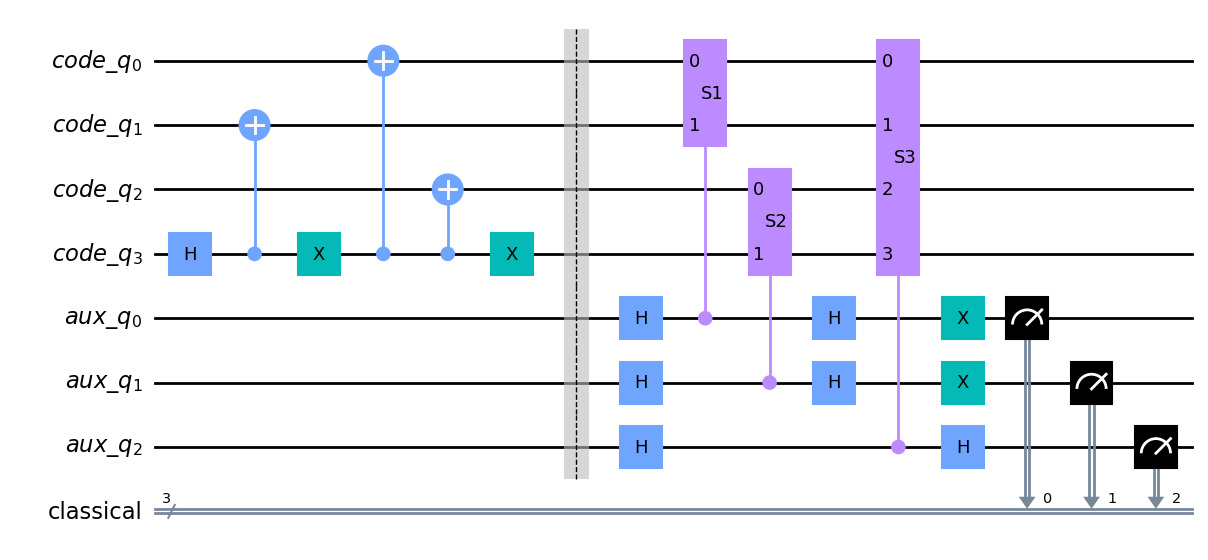

In [44]:
#Stabilisers taken from [1]
S1 = Stabiliser([0,1], 'z', 'S1')
S2 = Stabiliser([2,3], 'z', 'S2')
S3 = Stabiliser([0,1,2,3], 'x', 'S3')

#take a circuit without any errors and measure stabilisers
no_errors_circ = LQ1.lq_circ.copy()

#measure stabilisers - method taken
for i, stabiliser in enumerate([S1, S2, S3]):
    measure_stabiliser(stabiliser, no_errors_circ, i+4, i)
    
no_errors_circ.draw('mpl')

### The outcomes of stabiliser measurements (syndromes) should indicate no error present

In [45]:
#run a simulation
from qiskit import transpile

t_lq_circ = transpile(no_errors_circ, backend)
print('Syndrome measurements: ',backend.run(t_lq_circ).result().get_counts())

Syndrome measurements:  {'000': 1024}


### Introduce a random one-gate noise and measure stabilsers again

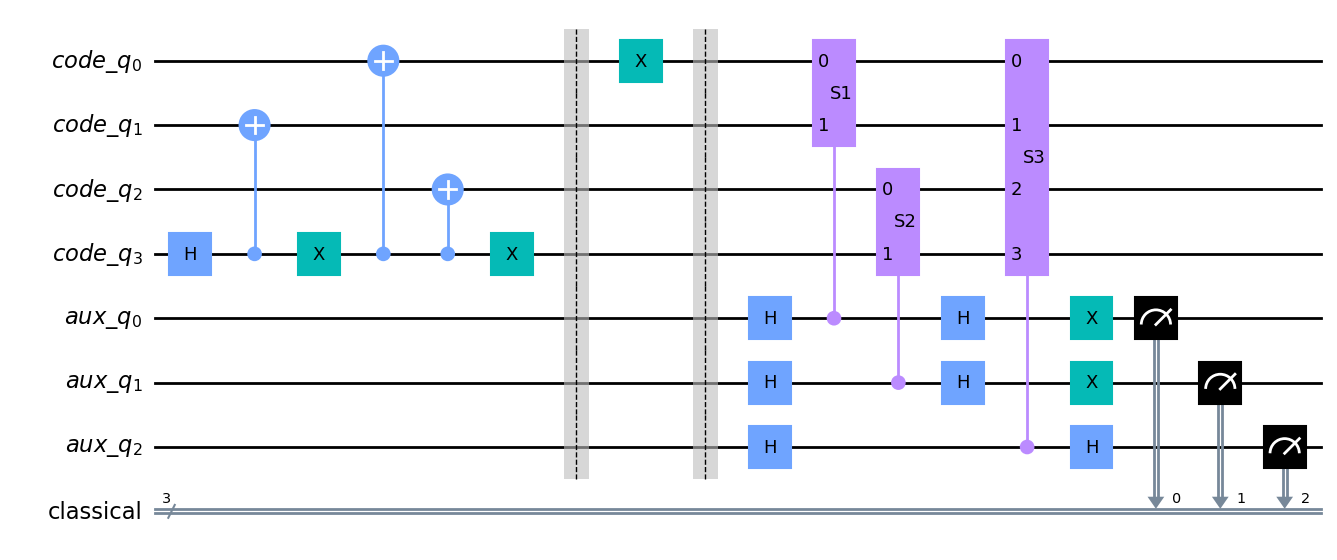

In [46]:
some_noisy_circuit = LQ1.lq_circ.copy()
#one-qubit noise chosed at random
apply_random_noise(some_noisy_circuit)
some_noisy_circuit.barrier()

#measure stabilisers
for i, stabiliser in enumerate([S1, S2, S3]):
    measure_stabiliser(stabiliser, some_noisy_circuit, i+4, i)

some_noisy_circuit.draw('mpl')

### The outcomes of syndrome readout should indicate an error is present 
### (if Z error, 1 in the X-stabiliser register; if X error, 1 in one of the Z registers)

In [47]:
#run simulation
t_some_noisy_circ = transpile(some_noisy_circuit, backend)
backend.run(t_some_noisy_circ).result().get_counts()

{'001': 1024}

### Demonstrate lattice surgery to produce a bell state

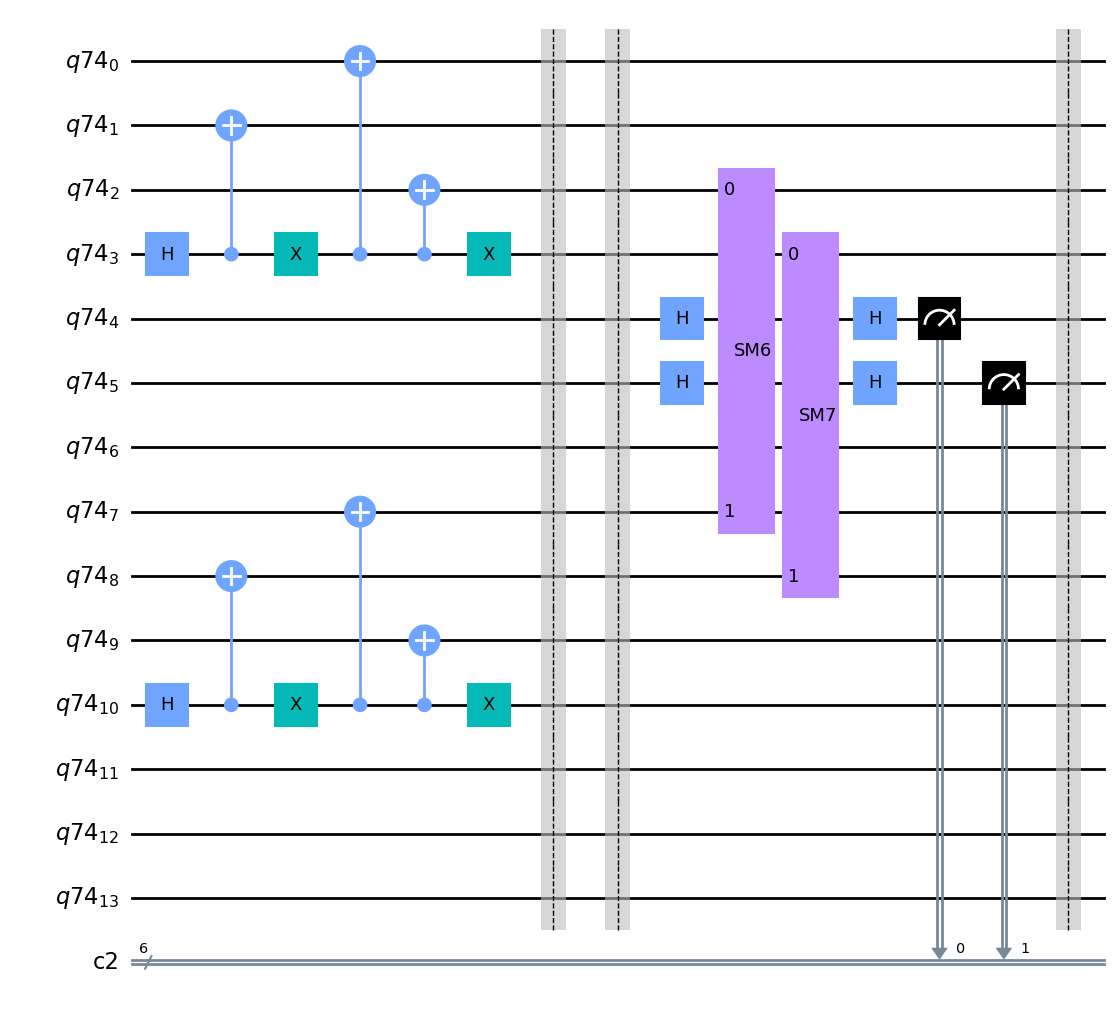

In [48]:
#LS: step 1) merge the qubits
LQ_m = LQ1.merge(LQ2)
merged_circ = LQ_m.lq_circ.copy()
#note the qubit ids differ from paper because the auxillary qubits are not pushed all the way down
SM6 = Stabiliser([2, 7], 'x', 'SM6')
SM7 = Stabiliser([3, 8], 'x', 'SM7')

measure_stabiliser(SM6, merged_circ, 4, 0)
measure_stabiliser(SM7, merged_circ, 5, 1)

merged_circ.barrier()
merged_circ.draw('mpl')

### The measurement outcomes are uniform as expected

In [49]:
t_merged_circ = transpile(merged_circ, backend)
backend.run(t_merged_circ).result().get_counts()


{'000001': 263, '000011': 260, '000010': 269, '000000': 232}

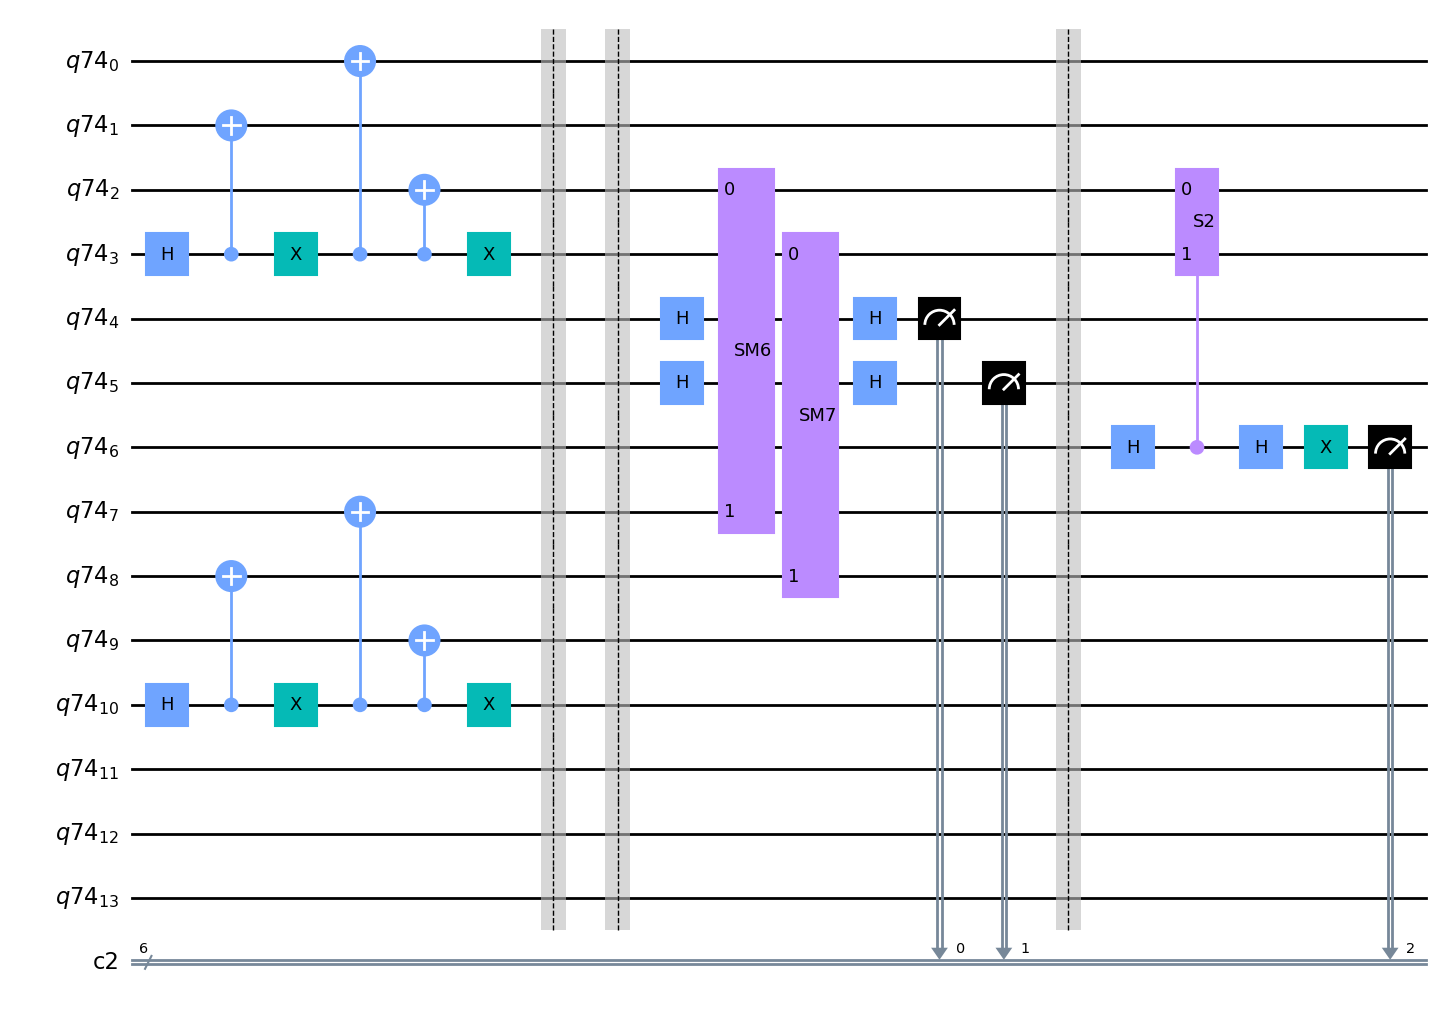

In [50]:
#step 2) split - obtain entangled state
#split by measuring either S2 on LQ1 or S1 on LQ2
split_circ = merged_circ.copy()
measure_stabiliser(S2, split_circ, 6, 2)
split_circ.draw('mpl')

### Again, each of the outcomes is equally likely

In [51]:
t_split_circ = transpile(split_circ, backend)
backend.run(t_split_circ).result().get_counts()
t_split_circ

### After performing the projective measurement, the expectation of any single-qubit Z should be 0

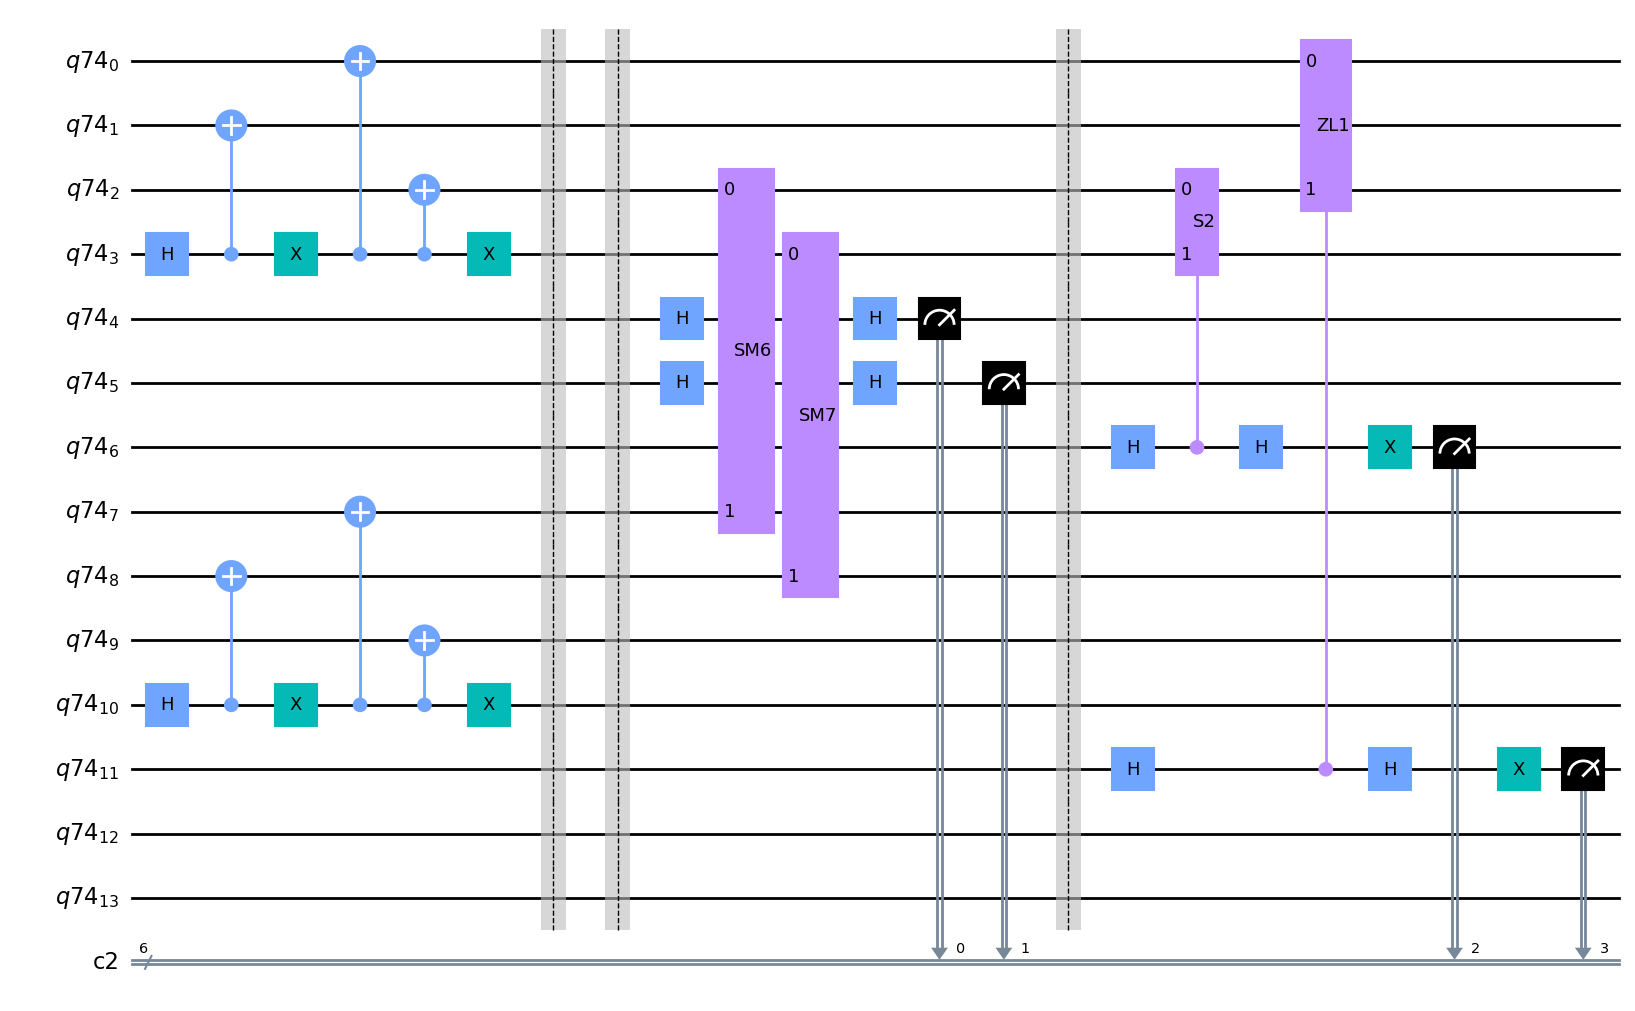

In [52]:
check_final_state = split_circ.copy()

#NOTE: The logical Z is obviously not a stabiliser - the class should be renamed appropriately to something like Operator
#as it supports functionality of a general logical operator
ZL1 = Stabiliser([0,2], 'z', 'ZL1')
#same with this function
measure_stabiliser(ZL1, check_final_state, 11, 3)

check_final_state.draw('mpl')

### Looking at outcome of c1[3], we see 0 and 1 are equally likely - thus <Z_L_1> = 0. First qubit is in an equal superposition in the logical computational basis (but we started with 0)

In [53]:
t_check = transpile(check_final_state, backend)
backend.run(t_check).result().get_counts()

{'001000': 52,
 '000111': 64,
 '001010': 65,
 '000101': 60,
 '001110': 84,
 '000010': 67,
 '000000': 52,
 '001101': 70,
 '001111': 58,
 '000110': 53,
 '000011': 58,
 '000001': 52,
 '001100': 64,
 '000100': 80,
 '001011': 64,
 '001001': 81}